In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
def read_one_file(path, return_if_data_loss=False, need_fill=True):
    # Read one raw data file in one hour.
    if_data_loss = False
    with open(path, "r") as f:
        lines = f.readlines()[1:]
    data = []
    for line in lines:
        line = line.strip().split(",")[:2]
        line = list(map(float, line))
        data.append(line)
    data = np.array(data)
    if data.shape[0] < 3600:
        warnings.warn("Data length is less than 3600.")
        if need_fill:
            data = np.vstack([data, np.zeros((3600 - data.shape[0], 2))])
        if_data_loss = True
    if data.shape[0] > 3600:
        warnings.warn("Data length is more than 3600.")
        data = data[:3600]
    if return_if_data_loss:
        return data, if_data_loss
    else:
        return data

# data = read_one_file("./data/bridge_measurement.FS")
data1 = read_one_file("./data/FS060100_200000.FS")
data2 = read_one_file("./data/FS020100_200000.FS")

def compute_uu(data):
    data[:, 1] = np.deg2rad(data[:, 1])
    ux = data[:, 0] * np.cos(data[:, 1])
    uy = data[:, 0] * np.sin(data[:, 1])

    u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
    beta_bar = np.arctan2(np.mean(uy), np.mean(ux))
    uu = ux * np.cos(beta_bar) + uy * np.sin(beta_bar) - u_bar
    return uu, u_bar

uu1, u_bar1 = compute_uu(data1)
uu2, u_bar2 = compute_uu(data2)

def compute_correlation(data_i, data_j):
    data_i_centered = data_i - np.mean(data_i)
    data_j_centered = data_j - np.mean(data_j)
    
    correlation = signal.correlate(
        data_i_centered, data_j_centered, mode="full"
    )
    
    # 使用最大值归一化（与理论值保持一致）
    corr_max = np.max(np.abs(correlation))
    return correlation / (corr_max if corr_max > 0 else 1.0)
    # return correlation / np.linalg.norm(correlation, ord=2)



z = 300
z0 = 0.01
H_ = 0.1
K = 0.4
zd = H_ - z0 / K
alpha_0 = 0.12
u10_1 = u_bar1 / (z / 10)**alpha_0
u10_2 = u_bar2 / (z / 10)**alpha_0
L = 1088
n = 101

idx_n = np.arange(0, n, 1)

wind_speeds = idx_n / (n-1) * (u10_2 - u10_1) + u10_1

# frequencies, psd, reference_psd = calculate_measured_psd(ux, uy, return_ref=True)

# u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
# beta_bar = np.arctan2(np.mean(uy), np.mean(ux))
# uu = ux * np.cos(beta_bar) + uy * np.sin(beta_bar) - u_bar

# frequencies, psd = signal.welch(uu, fs=1.0, window='hamming', 
#                                 scaling='density', nperseg=1024)
# frequencies = frequencies[1:]
# psd = psd[1:]

# mean_wind_speed = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
# u10 = mean_wind_speed / (76/10)**0.12


# u_star = K * u_bar / np.log((z - zd) / z0)
# f = frequencies * z / u_bar
# reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies

/tmp/ipykernel_9248/960080426.py:13: UserWarning: Data length is less than 3600.
  warnings.warn("Data length is less than 3600.")


In [4]:

from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="numpy", key=42, spectrum_type="kaimal-nd",)
fs = 1.0
T = int(data1.shape[0]/fs)
w_up = fs/2
N = int(T * w_up)
alpha_0 = 0.12
z0 = 0.01
H_ = 0.1
K = 0.4
simulator.update_parameters(
    H_bar=H_,
    z_0=z0,
    T=T,
    N=N,
    U_d=(u_bar1 + u_bar2)/2,
    alpha_0=alpha_0,
    w_up=w_up,
    C_x=1.5,
)
n = 101
Z = 300
position = np.zeros((n, 3))
position[:, 2] = Z
position[:, 1] = 5
position[:, 0] = np.linspace(0, L, n)
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
simulator.params

{'K': 0.4,
 'H_bar': 0.1,
 'z_0': 0.01,
 'alpha_0': 0.12,
 'C_x': 1.5,
 'C_y': 6.0,
 'C_z': 10.0,
 'w_up': 0.5,
 'N': 1800,
 'z_max': 450.0,
 'U_d': np.float64(8.038771261508682),
 'M': 3600,
 'T': 3600.0,
 'dt': 1.0,
 'dw': 0.0002777777777777778,
 'z_d': 0.07500000000000001,
 'backend': 'numpy'}

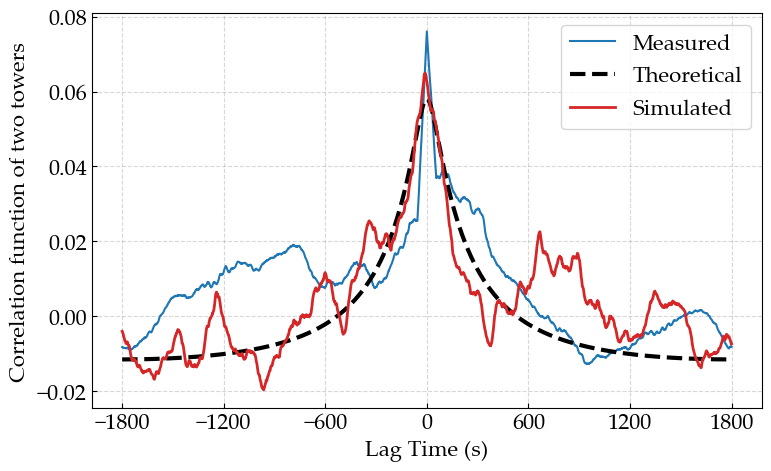

In [5]:
lag_times = np.arange(-len(uu1)+1, len(uu1)) / fs

correlation = compute_correlation(uu1, uu2)
visualizer = get_visualizer(backend="numpy", key=42, simulator=simulator)
plot_lag_times, plot_corr, theo_plot_times, theo_plot = \
        visualizer.plot_cross_correlation(
            samples,
            position,
            wind_speeds,
            show=False,
            component="u",
            indices=(0, -1),
            return_data=True
        )
    
mid = len(correlation) // 2
range_points = (len(theo_plot_times) / simulator.params["dt"]) // 2
measured_plot_corr = correlation[mid - int(range_points): mid + int(range_points) + 1]
measured_plot_lag_times = lag_times[mid - int(range_points): mid + int(range_points) + 1]

fig, ax = plt.subplots(figsize=(8, 5))
measured_plot_corr = measured_plot_corr / np.linalg.norm(measured_plot_corr, ord=2)
theo_plot = theo_plot / np.linalg.norm(theo_plot, ord=2)
plot_corr = plot_corr / np.linalg.norm(plot_corr, ord=2)
ax.plot(measured_plot_lag_times, measured_plot_corr, label="Measured", color="C0", )
ax.plot(theo_plot_times, theo_plot, label="Theoretical", color="black", 
        lw=3, ls="--")
ax.plot(plot_lag_times, plot_corr, label="Simulated", color="C3", lw=2)


ax.set_xlabel("Lag Time (s)")
ax.set_ylabel("Correlation function of two towers")
# ax.set(ylim=(-0.02, 0.08))
ax.xaxis.set_major_locator(plt.MultipleLocator(600))
ax.legend()
fig.tight_layout()

fig.savefig("./img/bridge_wind_correlation.png", dpi=300, bbox_inches="tight")
fig.savefig("./img/bridge_wind_correlation.pdf", dpi=300, bbox_inches="tight")


In [6]:
# visualizer = get_visualizer(backend="jax", key=42, simulator=simulator)
# visualizer.plot_psd(samples, position[:, -1], show_num=6, show=True, component="u")